In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
%pylab inline
plt.rcParams["figure.figsize"] = (8,6)

Populating the interactive namespace from numpy and matplotlib


In [5]:
def pca(X=np.array([]), no_dims=50):
    """
          Runs PCA on the NxD array X to reduce dimension
    """
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y

In [15]:
train_configs = np.loadtxt("configs_L_100_phi0.txt")
train_labels = np.loadtxt("labels_L_100_phi0.txt")
NC = len(train_configs)
L = len(train_configs[0])
print("loaded %i configurations for a system of size %i" %(NC, L))

loaded 4000 configurations for a system of size 100


In [16]:
def prepoc(config):
    return [2*i - 1 for i in config]

In [17]:
# prepare data for training
# exclude disorder strength between 1.5 and 2.5
# note that I change input to be in [-1, 1] instead of [0,1]
lambda_low = 1.95
lambda_high = 2.05
x = []
y = []
for i, label in enumerate(train_labels):
    if label < lambda_low:
        x.append(prepoc(train_configs[i]))
        y.append((1,0))
    if label > lambda_high:
        x.append(prepoc(train_configs[i]))
        y.append((0, 1))
x = np.array(x)
y = np.array(y)

In [18]:
PCA_coord = pca(x, no_dims=2)

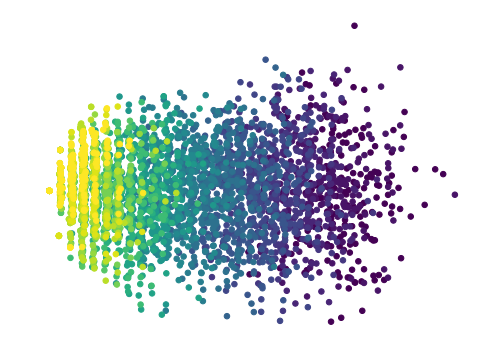

In [19]:
plt.scatter(PCA_coord[:,0], PCA_coord[:,1], 30, train_labels)
plt.axis('off')
plt.show()

In [20]:
hidden_layer = 100
# create model
model = Sequential()
model.add(Dense(hidden_layer, input_dim=L, kernel_initializer='random_normal', activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(2, kernel_initializer='random_normal', activation='softmax', kernel_regularizer=regularizers.l2(0.0)))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
model.fit(x, y, epochs=100, batch_size=10,  verbose=0)

In [23]:
test_x_1 = np.array(np.loadtxt("test_configs_L_100_phi0.txt"))
test_label = np.array(np.loadtxt("test_labels_L_100_phi0.txt"))
t_x_1 = [[2*i -1 for i in config] for config in test_x_1]

In [24]:
prediction = model.predict(t_x_1)

In [25]:
lambdas = list(np.sort(list(set(test_label))))
Nl = len(lambdas)
phase1 = np.zeros(Nl)
phase2 = np.zeros(Nl)
points = np.zeros(Nl)
lastT = 0.
for i, T in enumerate(test_label):
    j = lambdas.index(T)
    phase1[j]+=prediction[i:i+1, 0][0]
    phase2[j]+=prediction[i:i+1, 1][0]
    points[j]+=1.

for j in range(Nl):
    phase1[j] /= points[j]
    phase2[j] /= points[j]

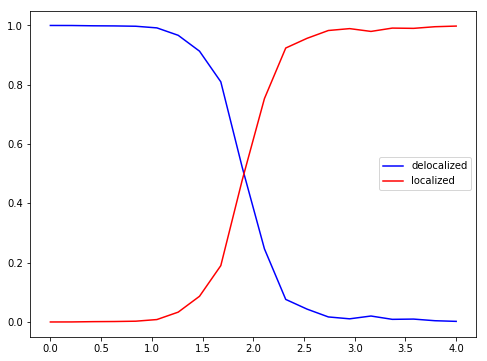

In [27]:
plt.plot(lambdas, phase1, 'b', label="delocalized")
plt.plot(lambdas, phase2, 'r', label="localized")
plt.legend()
plt.show()

In [28]:
test_x_2 = np.array(np.loadtxt("test_configs_L_100_phi10.txt"))
test_label_2 = np.array(np.loadtxt("test_labels_L_100_phi10.txt"))
t_x_2 = [[2*i -1 for i in config] for config in test_x_2]

In [29]:
prediction2 = model.predict(t_x_2)

In [30]:
lambdas = list(np.sort(list(set(test_label_2))))
Nl = len(lambdas)
phase1_2 = np.zeros(Nl)
phase2_2 = np.zeros(Nl)
points = np.zeros(Nl)
lastT = 0.
for i, T in enumerate(test_label_2):
    j = lambdas.index(T)
    phase1_2[j]+=prediction2[i:i+1, 0][0]
    phase2_2[j]+=prediction2[i:i+1, 1][0]
    points[j]+=1.

for j in range(Nl):
    phase1_2[j] /= points[j]
    phase2_2[j] /= points[j]

This is just a small reminder that we didn't actually learn anything about
the physics of localization, just where in the localized phase the particles would sit

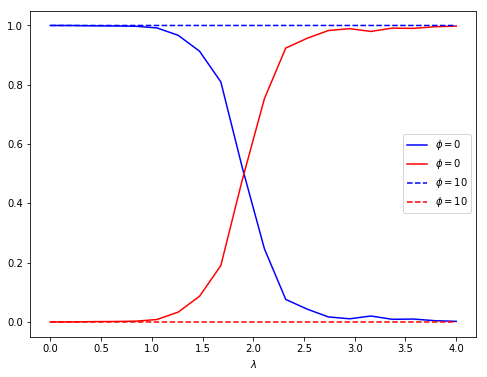

In [33]:
plt.plot(lambdas, phase1, 'b', label="$\phi = 0$")
plt.plot(lambdas, phase2, 'r', label="$\phi = 0$")
plt.plot(lambdas, phase1_2, 'b--', label="$\phi = 10$")
plt.plot(lambdas, phase2_2, 'r--', label="$\phi = 10$")
plt.legend()
plt.xlabel("$\lambda$")
plt.show()